In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
###################################
# TensorFlow wizardry
import tensorflow as tf
config = tf.ConfigProto()
 
# Don’t pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.05
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
 
# Create a session with the above options specified.
from keras import optimizers, regularizers
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Dense, Dropout, Input
from keras import backend as k

k.tensorflow_backend.set_session(tf.Session(config=config))
#k.tensorflow_backend.set_session(tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
###################################

Using TensorFlow backend.


In [3]:
#----------------------------------Import modules------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
from sklearn import preprocessing
sns.set_style("whitegrid")
np.random.seed(23)
import time
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as sm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict


In [4]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [5]:
pathds = '/home/user/01Code/00Datasets_final/'

In [6]:
#df_chunk = pd.read_csv(pathds+'SubsetAllSamples/ThirdCloneID10bal_minmax.csv', chunksize=1000)
#df = df_chunk.get_chunk(300000)
df = pd.read_csv(pathds+'SubsetAllSamples/ThirdCloneID10bal_minmax.csv')

In [7]:
df.shape

(455154, 49)

#### 4.2 Explaining the data

In [8]:
#if you don't have an intuitive sense of how imbalanced these two classes are, let's go visual
count_classes = pd.value_counts(df['class'], sort = True)
print('Class 0:', count_classes[0])
print('Class 1:', count_classes[1])
print('Proportion:', round(count_classes[0] / count_classes[1], 3), ': 1')

Class 0: 227577
Class 1: 227577
Proportion: 1.0 : 1


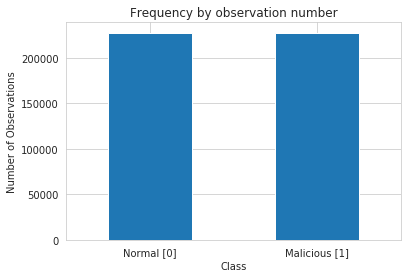

In [9]:
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), ['Normal [0]','Malicious [1]'])
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

In [10]:
#set random seed and percentage of test data
RANDOM_SEED = 23 #used to help randomly select the data points
TEST_PCT = 0.20 # 20% of the data

In [11]:
train, test_df = train_test_split(df, test_size=TEST_PCT, random_state=RANDOM_SEED)

+ df -> original dataset 
+ train -> subset of 80% from original dataset 
+ test_df -> subset of 20% from original dataset 

In [12]:
train_df, dev_df = train_test_split(train, test_size=TEST_PCT, random_state=RANDOM_SEED)

+ train -> subset of 80% from original dataset 
+ train_df -> subset of 80% from train
+ dev_df -> subset of 20% from train

In [13]:
# Check distribution of mal samples in train and test set
print(train_df.iloc[:, 48].sum()/train_df.shape[0]) 
print(dev_df.iloc[:, 48].sum()/dev_df.shape[0]) 
print(test_df.iloc[:, 48].sum()/test_df.shape[0])

0.5006728504830106
0.5012838997596979
0.4968197646955433


In [14]:
train_x = train_df.iloc[:, :48] 
dev_x = dev_df.iloc[:, :48] 
test_x = test_df.iloc[:, :48] 

+ train_x -> features of train_df **Training subset for AE**
+ dev_x -> features of dev_df **Validation subset for AE**
+ test_x -> features of test_df **Testing subset for ANN**

In [15]:
# Define the final train and test sets
train_y = train_df.iloc[:, 48]
dev_y = dev_df.iloc[:, 48]
test_y = test_df.iloc[:, 48]

+ train_y -> **Labels for supervised training of ANN**
+ dev_y -> labels of dev_df  *not used for AE neither ANN*
+ test_y -> labels of test_df  **Ground Truth for predictions of supervised ANN**

In [16]:
train_x =np.array(train_x)
dev_x =np.array(dev_x)
test_x = np.array(test_x)

train_y = np.array(train_y)
dev_y = np.array(dev_y)
test_y = np.array(test_y)

print(train_x.shape[1])

48


### Autoencoder Function

encoding_dim - 2

Epoch 94/300 78596/78596 [==============================] - 10s 125us/step 
- loss: 3.8990e-05 - acc: 0.0237 - 
        val_loss: 3.9704e-05 - val_acc: 0.0236

In [17]:
def ae(factor_enc_dim, enc_activation, dec_activation, 
                optimizer, loss):

    encoding_dim = int(int(train_x.shape[1])/factor_enc_dim)
    ### Define input layer
    input_data = Input(shape=(train_x.shape[1],))
    ### Define encoding layer #RELU
    encoded = Dense(encoding_dim, activation=enc_activation, name='encoded_bottle_neck')(input_data)
    ### Define decoding layer #SIMOID
    decoded = Dense(train_x.shape[1], activation=dec_activation)(encoded)
    ### Create the autoencoder model
    autoencoder = Model(input_data, decoded)
    autoencoder.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])
    
    print(autoencoder.summary())
    
    encoder = Model(input_data, encoded)
    encoded_train_x = encoder.predict(train_x)
    encoded_test_x = encoder.predict(test_x)
    
    return autoencoder,encoded_train_x,encoded_test_x

In [18]:
def sae(factor_enc_dim, output_activation,
        optimizer, loss):

    encoding_dim = int(int(train_x.shape[1])/factor_enc_dim)
    ### Define input layer
    input_data = Input(shape=(train_x.shape[1],))
    ### Define encoding layer
    encoded = Dense(encoding_dim, activation='relu', name='input_layer')(input_data)
    encoded = Dense(int(encoding_dim/2), activation='relu')(encoded) ##Stacked AE
    encoded_bottle_neck = Dense(int(encoding_dim/4), activation='relu', name='enc_bottle_neck')(encoded) ##Stacked AE
    
    ### Define decoding layer
    decoded = Dense(int(encoding_dim/2), activation='relu')(encoded_bottle_neck) ##Stacked AE
    decoded = Dense(encoding_dim, activation='relu')(decoded) ##Stacked AE
    decoded = Dense(train_x.shape[1], activation=output_activation)(decoded)
    
    ### Create the autoencoder model
    sae = Model(input_data, decoded)
    sae.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])
    
    print(sae.summary())

    encoder = Model(input_data, encoded_bottle_neck)
    encoded_train_x = encoder.predict(train_x)
    encoded_test_x = encoder.predict(test_x)
    
    return sae,encoded_train_x,encoded_test_x

In [19]:
def spae(factor_enc_dim, output_activation, 
                optimizer, loss):

    encoding_dim = int(int(train_x.shape[1])/factor_enc_dim)
    ### Define input layer
    input_data = Input(shape=(train_x.shape[1],))
    ### Define encoding layer
    encoded = Dense(encoding_dim, activity_regularizer=regularizers.l1(1e-4), activation='relu', name='encoded_bottle_neck')(input_data)
    ### Define decoding layer
    decoded = Dense(train_x.shape[1], activation=output_activation)(encoded)
    ### Create the autoencoder model
    autoencoder = Model(input_data, decoded)
    autoencoder.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])
    
    print(autoencoder.summary())
    
    encoder = Model(input_data, encoded)
    encoded_train_x = encoder.predict(train_x)
    encoded_test_x = encoder.predict(test_x)
    
    return autoencoder,encoded_train_x,encoded_test_x

In [20]:
def fit_ae(checkpoint_file, autoencoder,
           epochs, batch_size, shuffle):
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    cp = ModelCheckpoint(filepath=checkpoint_file,
                                   save_best_only=True,
                                   verbose=0)

    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)

    start_time = time.time()
    print(time.ctime(start_time))

    hist_auto = autoencoder.fit(train_x, train_x,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=shuffle,
                    verbose=1,
                    callbacks=[early_stopping, cp, tb],
                    validation_data=(dev_x, dev_x))

    elapsed_time = (time.time() - start_time)
    print("--- AE spent %s seconds ---" % elapsed_time)
    
    return hist_auto

In [21]:
def plot_hist_auto(hist_auto, fig_file):
    best_loss_value = hist_auto.history['loss'][-1]
    print('Best loss value:', best_loss_value)

    # Summarize history for loss
    plt.figure()
    plt.plot(hist_auto.history['loss'])
    plt.plot(hist_auto.history['val_loss'])
    plt.title('Autoencoder model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.savefig(fig_file)
    plt.show()
    
    return best_loss_value

In [22]:
def ann_2h(neurons,encoded_train_x,init_mode,activation_input,
               weight_constraint,dropout_rate,activation_output,
               loss,optimizer):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
                    kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
                    kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(36, activation="relu", kernel_initializer=init_mode)) #rezvy

    model.add(Dense(24, activation="relu", kernel_initializer=init_mode)) #rezvy
    model.add(BatchNormalization()) #commented for ex
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [23]:
def ann_1h_36n(neurons,encoded_train_x,init_mode,activation_input,
               weight_constraint,dropout_rate,activation_output,
               loss,optimizer):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
                    kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
                    kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(36, activation="relu", kernel_initializer=init_mode)) #rezvy
    model.add(BatchNormalization()) #commented for ex
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [24]:
def ann_1h_24n(neurons,encoded_train_x,init_mode,activation_input,
               weight_constraint,dropout_rate,activation_output,
               loss,optimizer):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
                    kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
                    kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(24, activation="relu", kernel_initializer=init_mode)) #rezvy
    model.add(BatchNormalization()) #commented for ex
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [25]:
def ann_fit(checkpoint_file,ann,enc_train_x,train_y,epochs,shuffle,batch_size):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    cp = ModelCheckpoint(filepath=checkpoint_file,
                                   save_best_only=True,
                                   verbose=0)

    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)

    start_time = time.time()
    print(time.ctime(start_time))

    history = ann.fit(enc_train_x,
                      train_y,
                      validation_split=0.2,
                      callbacks=[early_stopping],
                      epochs=epochs,
                      shuffle=shuffle,
                      batch_size=batch_size,
                      verbose=1)

    elapsed_time = (time.time() - start_time)
    print("--- ANN spent %s seconds ---" % elapsed_time)

    return history

In [26]:
def ann_predict(ann,enc_test_x):
    pred_ann_prob = ann.predict(enc_test_x)
    pred_ann_prob.shape
    pred_ann_prob = pred_ann_prob[:,0]
    pred_ann_01 = np.where(pred_ann_prob > 0.5, 1, 0)
    
    #Print accuracy
    acc_ann = accuracy_score(test_y, pred_ann_01)
    print('Overall accuracy of Neural Network model:', acc_ann)

    classiBM = "NN"
    preBM = (sm.precision_score(test_y, pred_ann_01)*100) 
    recallBM = (sm.recall_score(test_y, pred_ann_01)*100) 
    f1scoreBM = (sm.f1_score(test_y, pred_ann_01)*100)
    print(sm.classification_report(test_y, pred_ann_01))
    
    return pred_ann_prob, pred_ann_01

In [27]:
def plot_roc_cm(pred_ann_prob, pred_ann_01, roc_file, cm_file):
    false_positive_rate, recall, thresholds = roc_curve(test_y, pred_ann_prob)
    roc_auc = auc(false_positive_rate, recall)
    plt.figure()
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out (1-Specificity)')
    plt.savefig(roc_file)
    plt.show()
    
    cm = confusion_matrix(test_y, pred_ann_01)
    labels = ['Normal', 'Malicious']
    plt.figure(figsize=(8,6))
    sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="RdYlGn", vmin = 0.2);
    plt.title('Confusion Matrix')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.savefig(cm_file)
    plt.show()
    

loss: 2.7516e-05 - acc: 0.0407 

val_loss: 2.7072e-05 - val_acc: 0.0399

In [28]:
ae_sigmoid_adam_logcosh,enc_train_x_asal,enc_test_x_asal = ae(factor_enc_dim = 1.5,
                                                              enc_activation = 'relu',
                                                              dec_activation = 'sigmoid',
                                                              optimizer='Adam',
                                                              loss='logcosh')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48)                0         
_________________________________________________________________
encoded_bottle_neck (Dense)  (None, 32)                1568      
_________________________________________________________________
dense_1 (Dense)              (None, 48)                1584      
Total params: 3,152
Trainable params: 3,152
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
#ae_sigmoid_adam_logcosh = load_model('ae_sigmoid_adam_logcosh_redds10bal.h5')

In [30]:
hist_ae_sigmoid_adam_logcosh = fit_ae(checkpoint_file = "ae_sigmoid_adam_logcosh_redds10bal.h5",
                                        autoencoder = ae_sigmoid_adam_logcosh, 
                                        epochs = 200, 
                                        batch_size = 48, 
                                        shuffle = False)

Thu Jun  6 14:01:31 2019
Instructions for updating:
Use tf.cast instead.
Train on 291298 samples, validate on 72825 samples
Epoch 1/200
291298/291298 [==============================] - 16s 56us/step - loss: 0.0030 - acc: 0.0593 - val_loss: 6.0932e-05 - val_acc: 0.0612
Epoch 2/200
291298/291298 [==============================] - 16s 55us/step - loss: 5.5876e-05 - acc: 0.0606 - val_loss: 5.3459e-05 - val_acc: 0.0612
Epoch 3/200
291298/291298 [==============================] - 16s 56us/step - loss: 4.9057e-05 - acc: 0.0575 - val_loss: 4.7605e-05 - val_acc: 0.0526
Epoch 4/200
291298/291298 [==============================] - 16s 56us/step - loss: 4.7729e-05 - acc: 0.0462 - val_loss: 4.7337e-05 - val_acc: 0.0407
Epoch 5/200
291298/291298 [==============================] - 16s 56us/step - loss: 4.7555e-05 - acc: 0.0351 - val_loss: 4.7190e-05 - val_acc: 0.0300
Epoch 6/200
291298/291298 [==============================] - 16s 57us/step - loss: 4.7433e-05 - acc: 0.0259 - val_loss: 4.7092e-05 - va

Best loss value: 1.4083044855397788e-05


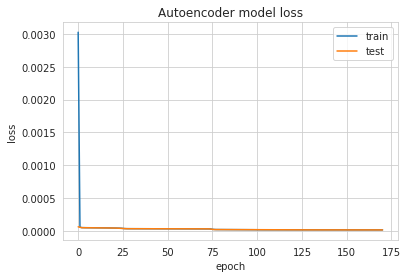

In [31]:
best_loss_value_ae_sigmoid_adam_logcosh = plot_hist_auto(hist_ae_sigmoid_adam_logcosh, './Figures/ae_sigmoid_adam_logcosh.png')

# Grid Search AE

In [32]:
# def aegs(factor_enc_dim=1.5,enc_activation='relu',dec_activation='sigmoid',optimizer='Adam',loss='logcosh'):

#     encoding_dim = int(int(train_x.shape[1])/1.5)
#     ### Define input layer
#     input_data = Input(shape=(train_x.shape[1],))
#     ### Define encoding layer #RELU
#     encoded = Dense(encoding_dim, activation=enc_activation, name='encoded_bottle_neck')(input_data)
#     ### Define decoding layer #SIMOID
#     decoded = Dense(train_x.shape[1], activation=dec_activation)(encoded)
#     ### Create the autoencoder model
#     autoencoder = Model(input_data, decoded)
#     autoencoder.compile(optimizer=optimizer,
#                         loss=loss,
#                         metrics=['accuracy'])
    
#     return autoencoder

In [33]:
# modelAE = KerasClassifier(build_fn = aegs)

In [34]:
# epochs = [100]
# batch_size = [48]

# factor_enc_dim = [1.5]
# enc_activation = ['relu', 'sigmoid']
# dec_activation = ['linear', 'sigmoid']
# optimizer = ['Adam']
# loss=['logcosh', 'mse']

In [35]:
# param_gridAE = dict(epochs=epochs, batch_size=batch_size, factor_enc_dim=factor_enc_dim, enc_activation=enc_activation, dec_activation=dec_activation, optimizer=optimizer, loss=loss)

In [36]:
# gridAE = GridSearchCV(estimator=modelAE, param_grid=param_gridAE, verbose=1, cv=2)
# early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [37]:
# start_time = time.time()
# print(time.ctime(start_time))

In [38]:
# resultAE = gridAE.fit(train_x, train_x,
#                 shuffle=True,
#                 verbose=1, 
#                 callbacks=[early_stopping],
#                 validation_data=(dev_x, dev_x))
# elapsed_time = (time.time() - start_time)

In [39]:
# print("--- AE spent %s seconds ---" %elapsed_time)

In [40]:
# print("Best: %f using %s" % (resultAE.best_score_, resultAE.best_params_))
# means = resultAE.cv_results_['mean_test_score']
# stds = resultAE.cv_results_['std_test_score']
# params = resultAE.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

39298/39298 [==============================] - 2s 41us/step - loss: 2.9830e-06 - acc: 0.1110 - val_loss: 4.9964e-06 - val_acc: 0.0225

0.084215 (0.044213) with: {'batch_size': 48, 'dec_activation': 'linear', 'enc_activation': 'sigmoid', 'epochs': 100, 'factor_enc_dim': 1.5, 'loss': 'logcosh', 'optimizer': 'Adam'}

In [41]:
ae_siglin_adam_logcosh,enc_train_x_aslal,enc_test_x_aslal = ae(factor_enc_dim = 1.5,
                                                              enc_activation = 'sigmoid',
                                                              dec_activation = 'linear',
                                                              optimizer='Adam',
                                                              loss='logcosh')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 48)                0         
_________________________________________________________________
encoded_bottle_neck (Dense)  (None, 32)                1568      
_________________________________________________________________
dense_2 (Dense)              (None, 48)                1584      
Total params: 3,152
Trainable params: 3,152
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
#ae_siglin_adam_logcosh = load_model('ae_siglin_adam_logcosh_redds10bal.h5')

In [43]:
hist_ae_siglin_adam_logcosh = fit_ae(checkpoint_file = "ae_siglin_adam_logcosh_redds10bal.h5",
                                        autoencoder = ae_siglin_adam_logcosh, 
                                        epochs = 200, 
                                        batch_size = 48, 
                                        shuffle = False)

Thu Jun  6 14:40:11 2019
Train on 291298 samples, validate on 72825 samples
Epoch 1/200
291298/291298 [==============================] - 10s 36us/step - loss: 0.0041 - acc: 0.0764 - val_loss: 8.5461e-05 - val_acc: 0.0570
Epoch 2/200
291298/291298 [==============================] - 10s 36us/step - loss: 4.8990e-05 - acc: 0.0368 - val_loss: 2.8091e-05 - val_acc: 0.0654
Epoch 3/200
291298/291298 [==============================] - 10s 35us/step - loss: 2.1206e-05 - acc: 0.0350 - val_loss: 1.6585e-05 - val_acc: 0.0440
Epoch 4/200
291298/291298 [==============================] - 10s 35us/step - loss: 1.3374e-05 - acc: 0.0362 - val_loss: 1.1180e-05 - val_acc: 0.0498
Epoch 5/200
291298/291298 [==============================] - 10s 36us/step - loss: 9.7674e-06 - acc: 0.0361 - val_loss: 7.9525e-06 - val_acc: 0.0345
Epoch 6/200
291298/291298 [==============================] - 10s 36us/step - loss: 7.7298e-06 - acc: 0.0361 - val_loss: 6.8255e-06 - val_acc: 0.0224
Epoch 7/200
291298/291298 [=======

Best loss value: 1.8328752667281846e-06


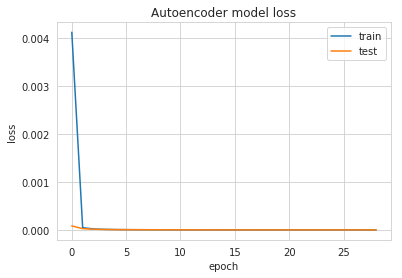

In [44]:
best_loss_value_ae_siglin_adam_logcosh = plot_hist_auto(hist_ae_siglin_adam_logcosh, './Figures/hist_ae_siglin_adam_logcosh.png')

In [45]:
ae_sigmoid_adam_mse,enc_train_x_asam,enc_test_x_asam = ae(factor_enc_dim = 1.5,
                                                          enc_activation = 'relu',
                                                          dec_activation = 'sigmoid',
                                                          optimizer='Adam',
                                                          loss='mean_squared_error')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 48)                0         
_________________________________________________________________
encoded_bottle_neck (Dense)  (None, 32)                1568      
_________________________________________________________________
dense_3 (Dense)              (None, 48)                1584      
Total params: 3,152
Trainable params: 3,152
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
#ae_sigmoid_adam_mse = load_model('ae_sigmoid_adam_mse_redds10bal.h5')

In [47]:
hist_ae_sigmoid_adam_mse = fit_ae(checkpoint_file = "ae_sigmoid_adam_mse_redds10bal.h5",
                                  autoencoder = ae_sigmoid_adam_mse, 
                                  epochs = 200, 
                                  batch_size = 48,
                                  shuffle = False)

Thu Jun  6 14:45:15 2019
Train on 291298 samples, validate on 72825 samples
Epoch 1/200
291298/291298 [==============================] - 10s 35us/step - loss: 0.0067 - acc: 0.0091 - val_loss: 1.2815e-04 - val_acc: 0.0000e+00
Epoch 2/200
291298/291298 [==============================] - 10s 35us/step - loss: 1.0853e-04 - acc: 0.0000e+00 - val_loss: 9.7881e-05 - val_acc: 0.0000e+00
Epoch 3/200
291298/291298 [==============================] - 10s 35us/step - loss: 9.6712e-05 - acc: 0.0000e+00 - val_loss: 9.5692e-05 - val_acc: 0.0000e+00
Epoch 4/200
291298/291298 [==============================] - 10s 35us/step - loss: 9.5901e-05 - acc: 0.0000e+00 - val_loss: 9.5327e-05 - val_acc: 0.0000e+00
Epoch 5/200
291298/291298 [==============================] - 10s 35us/step - loss: 9.5622e-05 - acc: 0.0000e+00 - val_loss: 9.5150e-05 - val_acc: 0.0000e+00
Epoch 6/200
291298/291298 [==============================] - 10s 35us/step - loss: 9.5397e-05 - acc: 0.0000e+00 - val_loss: 9.4734e-05 - val_acc: 0

Best loss value: 3.167287426632356e-05


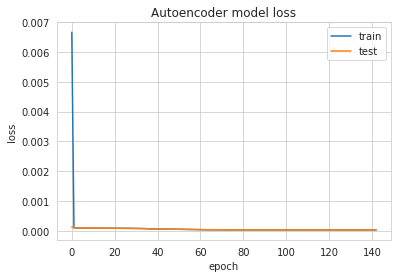

In [48]:
best_loss_value_ae_sigmoid_adam_mse  = plot_hist_auto(hist_ae_sigmoid_adam_mse, './Figures/hist_ae_sigmoid_adam_mse.png')

In [49]:
sae_sigmoid_adam_mse,enc_train_x_ssam,enc_test_x_ssam = sae(factor_enc_dim = 1.5,
                                                          output_activation = 'sigmoid',
                                                          optimizer='Adam',
                                                          loss='mean_squared_error')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 48)                0         
_________________________________________________________________
input_layer (Dense)          (None, 32)                1568      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
enc_bottle_neck (Dense)      (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_6 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_7 (Dense)              (None, 48)                1584      
Total para

In [50]:
#sae_sigmoid_adam_mse = load_model('sae_sigmoid_adam_mse_redds10bal.h5')

In [51]:
hist_sae_sigmoid_adam_mse = fit_ae(checkpoint_file = "sae_sigmoid_adam_mse_redds10bal.h5",
                                        autoencoder = sae_sigmoid_adam_mse, 
                                        epochs = 200, 
                                        batch_size = 48, 
                                        shuffle = False)

Thu Jun  6 15:10:25 2019
Train on 291298 samples, validate on 72825 samples
Epoch 1/200
291298/291298 [==============================] - 20s 69us/step - loss: 0.0324 - acc: 0.0519 - val_loss: 0.0244 - val_acc: 0.0482
Epoch 2/200
291298/291298 [==============================] - 20s 68us/step - loss: 0.0188 - acc: 0.2056 - val_loss: 0.0169 - val_acc: 0.2803
Epoch 3/200
291298/291298 [==============================] - 20s 68us/step - loss: 0.0168 - acc: 0.2981 - val_loss: 0.0167 - val_acc: 0.3250
Epoch 4/200
291298/291298 [==============================] - 20s 70us/step - loss: 0.0167 - acc: 0.3164 - val_loss: 0.0166 - val_acc: 0.3005
Epoch 5/200
291298/291298 [==============================] - 20s 68us/step - loss: 0.0166 - acc: 0.3100 - val_loss: 0.0166 - val_acc: 0.2912
Epoch 6/200
291298/291298 [==============================] - 20s 68us/step - loss: 0.0165 - acc: 0.3140 - val_loss: 0.0160 - val_acc: 0.2880
Epoch 7/200
291298/291298 [==============================] - 19s 67us/step - l

Best loss value: 0.01160121386875563


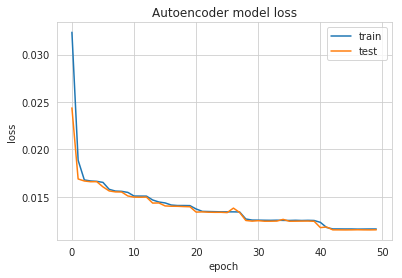

In [52]:
best_loss_value_sae_sigmoid_adam_mse  = plot_hist_auto(hist_sae_sigmoid_adam_mse, './Figures/hist_sae_sigmoid_adam_mse.png')

In [53]:
sae_sigmoid_adam_logcosh,enc_train_x_ssal,enc_test_x_ssal = sae(factor_enc_dim = 1.5,
                                                              output_activation = 'sigmoid',
                                                              optimizer='Adam',
                                                              loss='logcosh')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 48)                0         
_________________________________________________________________
input_layer (Dense)          (None, 32)                1568      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
enc_bottle_neck (Dense)      (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_10 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_11 (Dense)             (None, 48)                1584      
Total para

In [54]:
# from keras.utils import plot_model 
# plot_model(sae_sigmoid_adam_logcosh, to_file='sae_sigmoid_adam_logcosh.png')
# from PIL import Image
# image = Image.open('sae_sigmoid_adam_logcosh.png')
# image.show()

In [55]:
#sae_sigmoid_adam_logcosh = load_model('sae_sigmoid_adam_logcosh_redds10bal.h5')

In [56]:
hist_sae_sigmoid_adam_logcosh = fit_ae(checkpoint_file = "sae_sigmoid_adam_logcosh_redds10bal.h5",
                                        autoencoder = sae_sigmoid_adam_logcosh, 
                                        epochs = 200, 
                                        batch_size = 48, 
                                        shuffle = False)

Thu Jun  6 15:26:56 2019
Train on 291298 samples, validate on 72825 samples
Epoch 1/200
291298/291298 [==============================] - 20s 69us/step - loss: 0.0099 - acc: 0.2118 - val_loss: 0.0063 - val_acc: 0.3511
Epoch 2/200
291298/291298 [==============================] - 20s 68us/step - loss: 0.0058 - acc: 0.3370 - val_loss: 0.0053 - val_acc: 0.3210
Epoch 3/200
291298/291298 [==============================] - 20s 69us/step - loss: 0.0052 - acc: 0.3228 - val_loss: 0.0050 - val_acc: 0.3269
Epoch 4/200
291298/291298 [==============================] - 20s 68us/step - loss: 0.0048 - acc: 0.3225 - val_loss: 0.0044 - val_acc: 0.3228
Epoch 5/200
291298/291298 [==============================] - 20s 68us/step - loss: 0.0044 - acc: 0.3299 - val_loss: 0.0044 - val_acc: 0.3279
Epoch 6/200
291298/291298 [==============================] - 21s 72us/step - loss: 0.0044 - acc: 0.3326 - val_loss: 0.0043 - val_acc: 0.3320
Epoch 7/200
291298/291298 [==============================] - 21s 71us/step - l

Best loss value: 0.0019803600962032515


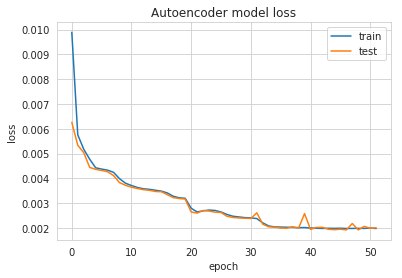

In [57]:
best_loss_value_sae_sigmoid_adam_logcosh  = plot_hist_auto(hist_sae_sigmoid_adam_logcosh, './Figures/hist_sae_sigmoid_adam_logcosh.png')

In [58]:
spae_sigmoid_adam_logcosh,enc_train_x_spaesal,enc_test_x_spaesal = spae(factor_enc_dim = 1.5,
                                                              output_activation = 'sigmoid',
                                                              optimizer='Adam',
                                                              loss='logcosh')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 48)                0         
_________________________________________________________________
encoded_bottle_neck (Dense)  (None, 32)                1568      
_________________________________________________________________
dense_12 (Dense)             (None, 48)                1584      
Total params: 3,152
Trainable params: 3,152
Non-trainable params: 0
_________________________________________________________________
None


In [59]:
#spae_sigmoid_adam_logcosh = load_model('spae_sigmoid_adam_logcosh_redds10bal.h5')

In [60]:
hist_spae_sigmoid_adam_logcosh = fit_ae(checkpoint_file = "spae_sigmoid_adam_logcosh_redds10bal.h5",
                                        autoencoder = spae_sigmoid_adam_logcosh, 
                                        epochs = 200, 
                                        batch_size = 48, 
                                        shuffle = False)

Thu Jun  6 15:44:45 2019
Train on 291298 samples, validate on 72825 samples
Epoch 1/200
291298/291298 [==============================] - 14s 47us/step - loss: 0.0277 - acc: 0.2502 - val_loss: 0.0203 - val_acc: 0.0612
Epoch 2/200
291298/291298 [==============================] - 14s 48us/step - loss: 0.0188 - acc: 0.0606 - val_loss: 0.0177 - val_acc: 0.0612
Epoch 3/200
291298/291298 [==============================] - 14s 48us/step - loss: 0.0172 - acc: 0.0606 - val_loss: 0.0167 - val_acc: 0.0612
Epoch 4/200
291298/291298 [==============================] - 15s 51us/step - loss: 0.0165 - acc: 0.0606 - val_loss: 0.0162 - val_acc: 0.0612
Epoch 5/200
291298/291298 [==============================] - 15s 50us/step - loss: 0.0161 - acc: 0.0603 - val_loss: 0.0159 - val_acc: 0.0567
Epoch 6/200
291298/291298 [==============================] - 14s 48us/step - loss: 0.0158 - acc: 0.0500 - val_loss: 0.0157 - val_acc: 0.0352
Epoch 7/200
291298/291298 [==============================] - 14s 48us/step - l

Best loss value: 0.014212557768406998


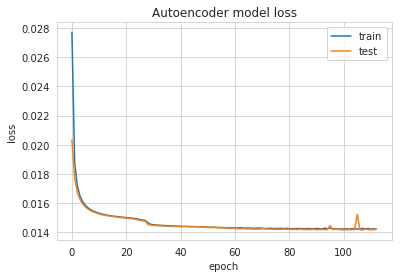

In [61]:
best_loss_value_spae_sigmoid_adam_logcosh = plot_hist_auto(hist_spae_sigmoid_adam_logcosh, './Figures/spae_sigmoid_adam_logcosh.png')

In [62]:
loss_valueDict = {
    'loss_value_ae_sigmoid_adam_logcosh': best_loss_value_ae_sigmoid_adam_logcosh,
    'loss_value_ae_sigmoid_adam_mse': best_loss_value_ae_sigmoid_adam_mse,
    'loss_value_sae_sigmoid_adam_logcosh': best_loss_value_sae_sigmoid_adam_logcosh,
    'loss_value_sae_sigmoid_adam_mse': best_loss_value_sae_sigmoid_adam_mse,
    'loss_value_spae_sigmoid_adam_logcosh': best_loss_value_spae_sigmoid_adam_logcosh,
    'loss_value_ae_siglin_adam_logcosh': best_loss_value_ae_siglin_adam_logcosh
    }

In [63]:
loss_valueDict

{'loss_value_ae_sigmoid_adam_logcosh': 1.4083044855397788e-05,
 'loss_value_ae_sigmoid_adam_mse': 3.167287426632356e-05,
 'loss_value_sae_sigmoid_adam_logcosh': 0.0019803600962032515,
 'loss_value_sae_sigmoid_adam_mse': 0.01160121386875563,
 'loss_value_spae_sigmoid_adam_logcosh': 0.014212557768406998,
 'loss_value_ae_siglin_adam_logcosh': 1.8328752667281846e-06}

In [64]:
print(enc_train_x_asal.shape[1])
print(enc_test_x_asal.shape[1])

print(enc_train_x_spaesal.shape[1])
print(enc_test_x_spaesal.shape[1])

print(enc_train_x_asam.shape[1])
print(enc_test_x_asam.shape[1])

print(enc_train_x_ssal.shape[1])
print(enc_test_x_ssal.shape[1])

print(enc_train_x_ssam.shape[1])
print(enc_test_x_ssam.shape[1])

32
32
32
32
32
32
8
8
8
8


In [65]:
print(enc_train_x_aslal.shape)
print(enc_test_x_aslal.shape)

(291298, 32)
(91031, 32)


In [66]:
ann36n_unisoftsigbinlosadam = ann_1h_36n(neurons=48,
                                      encoded_train_x=enc_train_x_aslal,
                                      init_mode='uniform',
                                      activation_input='softsign',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 48)                1584      
_________________________________________________________________
dense_14 (Dense)             (None, 36)                1764      
_________________________________________________________________
batch_normalization_1 (Batch (None, 36)                144       
_________________________________________________________________
dropout_1 (Dropout)          (None, 36)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 37        
Total params: 3,529
Trainable params: 3,457
Non-trainable params: 72
_________________________________________________________________
None


In [67]:
hist_ann36n_unisoftsigbinlosadam = ann_fit(checkpoint_file = "ann36n_unisoftsigbinlosadam_redds10bal.h5",
                                        ann = ann36n_unisoftsigbinlosadam,
                                        enc_train_x = enc_train_x_aslal,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = False,
                                        batch_size = 48)

Thu Jun  6 16:12:00 2019
Train on 233038 samples, validate on 58260 samples
Epoch 1/200
233038/233038 [==============================] - 20s 85us/step - loss: 0.6215 - acc: 0.6359 - val_loss: 0.6199 - val_acc: 0.6574
Epoch 2/200
233038/233038 [==============================] - 19s 82us/step - loss: 0.6143 - acc: 0.6413 - val_loss: 0.6962 - val_acc: 0.6170
Epoch 3/200
233038/233038 [==============================] - 19s 82us/step - loss: 0.6074 - acc: 0.6463 - val_loss: 1.3757 - val_acc: 0.5161
Epoch 4/200
233038/233038 [==============================] - 19s 82us/step - loss: 0.6016 - acc: 0.6520 - val_loss: 1.3239 - val_acc: 0.5159
Epoch 5/200
233038/233038 [==============================] - 19s 81us/step - loss: 0.5976 - acc: 0.6567 - val_loss: 1.8846 - val_acc: 0.5018
Epoch 6/200
233038/233038 [==============================] - 19s 81us/step - loss: 0.5947 - acc: 0.6609 - val_loss: 1.5728 - val_acc: 0.5074
--- ANN spent 115.0724401473999 seconds ---


Best loss value: 0.594657290451849


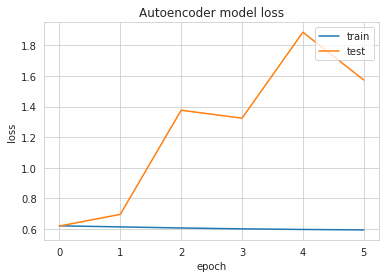

In [68]:
best_loss_value_ann36n_unisoftsigbinlosadam = plot_hist_auto(hist_ann36n_unisoftsigbinlosadam, './Figures/ann36_unisoftsigbinlosadam.png')

In [69]:
pred_ann36n_prob_unisoftsigbinlosadam, pred_ann36n_01_unisoftsigbinlosadam = ann_predict(ann36n_unisoftsigbinlosadam,enc_test_x_aslal)

Overall accuracy of Neural Network model: 0.5031912205732113
              precision    recall  f1-score   support

           0       1.00      0.01      0.03     45805
           1       0.50      1.00      0.67     45226

   micro avg       0.50      0.50      0.50     91031
   macro avg       0.75      0.51      0.35     91031
weighted avg       0.75      0.50      0.34     91031



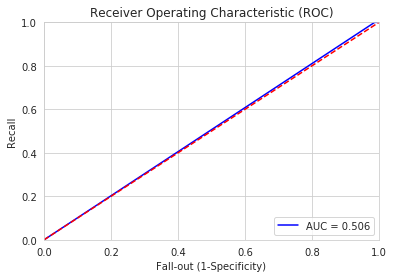

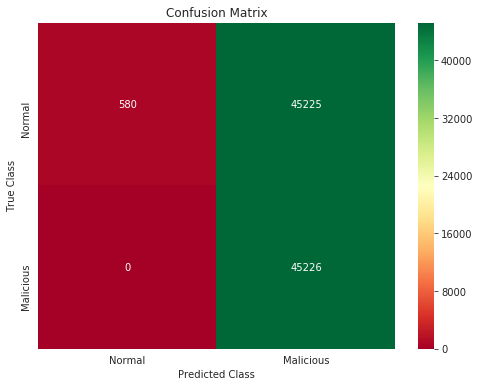

In [70]:
plot_roc_cm(pred_ann36n_01_unisoftsigbinlosadam, pred_ann36n_01_unisoftsigbinlosadam, './Figures/ROC_ann36n_unisoftsigbinlosadam_redds10bal.png', './Figures/CM_ann36n_unisoftsigbinlosadam_redds10bal.png')

In [71]:
ann24n_unisoftsigbinlosadam = ann_1h_24n(neurons=48,
                                      encoded_train_x=enc_train_x_aslal,
                                      init_mode='uniform',
                                      activation_input='softsign',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 48)                1584      
_________________________________________________________________
dense_17 (Dense)             (None, 24)                1176      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24)                96        
_________________________________________________________________
dropout_2 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 25        
Total params: 2,881
Trainable params: 2,833
Non-trainable params: 48
_________________________________________________________________
None


In [72]:
hist_ann24n_unisoftsigbinlosadam = ann_fit(checkpoint_file = "ann24n_unisoftsigbinlosadam_redds10bal.h5",
                                        ann = ann24n_unisoftsigbinlosadam,
                                        enc_train_x = enc_train_x_aslal,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 48)

Thu Jun  6 16:13:58 2019
Train on 233038 samples, validate on 58260 samples
Epoch 1/200
233038/233038 [==============================] - 20s 84us/step - loss: 0.6217 - acc: 0.6351 - val_loss: 0.7034 - val_acc: 0.6086
Epoch 2/200
233038/233038 [==============================] - 19s 82us/step - loss: 0.6129 - acc: 0.6410 - val_loss: 2.2226 - val_acc: 0.5018
Epoch 3/200
233038/233038 [==============================] - 19s 83us/step - loss: 0.6065 - acc: 0.6477 - val_loss: 1.7373 - val_acc: 0.4982
Epoch 4/200
233038/233038 [==============================] - 19s 83us/step - loss: 0.6021 - acc: 0.6517 - val_loss: 1.9570 - val_acc: 0.4982
Epoch 5/200
233038/233038 [==============================] - 19s 81us/step - loss: 0.5976 - acc: 0.6564 - val_loss: 0.5930 - val_acc: 0.6718
Epoch 6/200
233038/233038 [==============================] - 19s 82us/step - loss: 0.5940 - acc: 0.6610 - val_loss: 0.6451 - val_acc: 0.5898
Epoch 7/200
233038/233038 [==============================] - 19s 83us/step - l

Best loss value: 0.5869546256831744


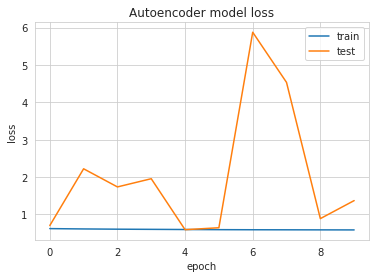

In [73]:
best_loss_value_ann24n_unisoftsigbinlosadam = plot_hist_auto(hist_ann24n_unisoftsigbinlosadam, './Figures/ann24_unisoftsigbinlosadam.png')

In [74]:
pred_ann24n_prob_unisoftsigbinlosadam, pred_ann24n_01_unisoftsigbinlosadam = ann_predict(ann24n_unisoftsigbinlosadam,enc_test_x_aslal)

Overall accuracy of Neural Network model: 0.5032131911107205
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     45805
           1       1.00      0.00      0.00     45226

   micro avg       0.50      0.50      0.50     91031
   macro avg       0.75      0.50      0.33     91031
weighted avg       0.75      0.50      0.34     91031



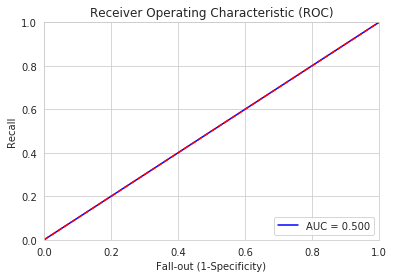

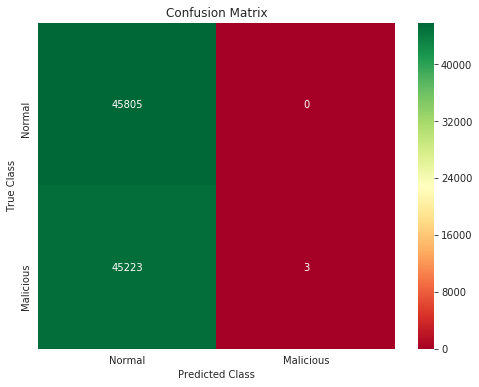

In [75]:
plot_roc_cm(pred_ann24n_01_unisoftsigbinlosadam, pred_ann24n_01_unisoftsigbinlosadam, './Figures/ROC_ann24n_unisoftsigbinlosadam_redds10bal.png', './Figures/CM_ann24n_unisoftsigbinlosadam_redds10bal.png')

In [76]:
ann_2h_unisoftsigbinlosadam = ann_2h(neurons=48,
                                      encoded_train_x=enc_train_x_aslal,
                                      init_mode='uniform',
                                      activation_input='softsign',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 48)                1584      
_________________________________________________________________
dense_20 (Dense)             (None, 36)                1764      
_________________________________________________________________
dense_21 (Dense)             (None, 24)                888       
_________________________________________________________________
batch_normalization_3 (Batch (None, 24)                96        
_________________________________________________________________
dropout_3 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 25        
Total params: 4,357
Trainable params: 4,309
Non-trainable params: 48
_________________________________________________________________
None


In [77]:
hist_ann_2h_unisoftsigbinlosadam = ann_fit(checkpoint_file = "ann_2h_unisoftsigbinlosadam_redds10bal.h5",
                                        ann = ann_2h_unisoftsigbinlosadam,
                                        enc_train_x = enc_train_x_aslal,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 48)

Thu Jun  6 16:17:13 2019
Train on 233038 samples, validate on 58260 samples
Epoch 1/200
233038/233038 [==============================] - 21s 89us/step - loss: 0.6221 - acc: 0.6353 - val_loss: 0.7048 - val_acc: 0.6119
Epoch 2/200
233038/233038 [==============================] - 20s 86us/step - loss: 0.6140 - acc: 0.6407 - val_loss: 1.1699 - val_acc: 0.5378
Epoch 3/200
233038/233038 [==============================] - 20s 86us/step - loss: 0.6074 - acc: 0.6457 - val_loss: 0.7534 - val_acc: 0.6083
Epoch 4/200
233038/233038 [==============================] - 20s 88us/step - loss: 0.6000 - acc: 0.6530 - val_loss: 2.4546 - val_acc: 0.4982
Epoch 5/200
233038/233038 [==============================] - 21s 88us/step - loss: 0.5948 - acc: 0.6602 - val_loss: 1.9418 - val_acc: 0.5038
Epoch 6/200
233038/233038 [==============================] - 21s 89us/step - loss: 0.5907 - acc: 0.6664 - val_loss: 3.3407 - val_acc: 0.5018
--- ANN spent 123.06759738922119 seconds ---


Best loss value: 0.5907241650541672


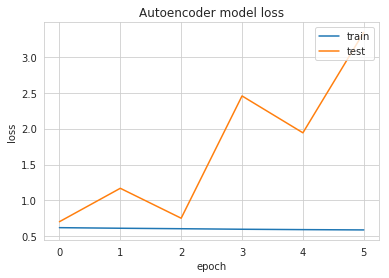

In [78]:
best_loss_value_ann_2h_unisoftsigbinlosadam = plot_hist_auto(hist_ann_2h_unisoftsigbinlosadam, './Figures/ann_2h_unisoftsigbinlosadam.png')

In [79]:
pred_ann_2h_prob_unisoftsigbinlosadam, pred_ann_2h_01_unisoftsigbinlosadam = ann_predict(ann_2h_unisoftsigbinlosadam,enc_test_x_aslal)

Overall accuracy of Neural Network model: 0.4968197646955433
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     45805
           1       0.50      1.00      0.66     45226

   micro avg       0.50      0.50      0.50     91031
   macro avg       0.25      0.50      0.33     91031
weighted avg       0.25      0.50      0.33     91031



/home/user/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/user/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/user/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


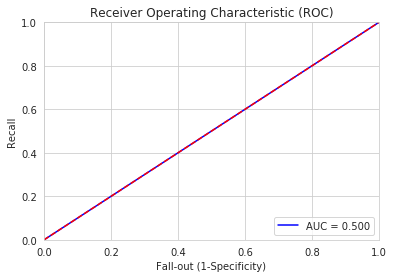

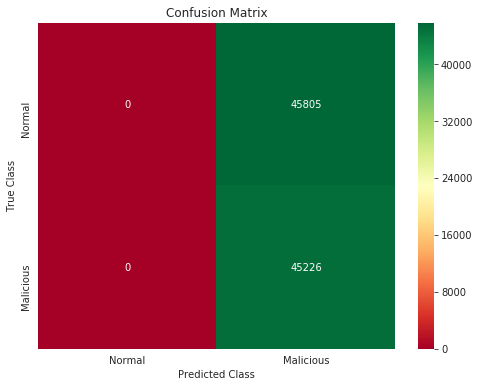

In [80]:
plot_roc_cm(pred_ann_2h_01_unisoftsigbinlosadam, pred_ann_2h_01_unisoftsigbinlosadam, './Figures/ROC_ann_2h_unisoftsigbinlosadam_redds10bal.png', './Figures/CM_ann_2h_unisoftsigbinlosadam_redds10bal.png')

In [81]:
ann_24n_unisoftsigbinlosadam = ann_1h_24n(neurons=48,
                                      encoded_train_x=train_x,
                                      init_mode='uniform',
                                      activation_input='softsign',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 48)                2352      
_________________________________________________________________
dense_24 (Dense)             (None, 24)                1176      
_________________________________________________________________
batch_normalization_4 (Batch (None, 24)                96        
_________________________________________________________________
dropout_4 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 25        
Total params: 3,649
Trainable params: 3,601
Non-trainable params: 48
_________________________________________________________________
None


In [82]:
hist_ann_24n_unisoftsigbinlosadam = ann_fit(checkpoint_file = "ann_24n_unisoftsigbinlosadam_redds10bal.h5",
                                        ann = ann_24n_unisoftsigbinlosadam,
                                        enc_train_x = train_x,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 48)

Thu Jun  6 16:19:19 2019
Train on 233038 samples, validate on 58260 samples
Epoch 1/200
233038/233038 [==============================] - 20s 86us/step - loss: 0.5200 - acc: 0.7185 - val_loss: 0.4649 - val_acc: 0.7616
Epoch 2/200
233038/233038 [==============================] - 19s 83us/step - loss: 0.4412 - acc: 0.7772 - val_loss: 0.4013 - val_acc: 0.8051
Epoch 3/200
233038/233038 [==============================] - 20s 84us/step - loss: 0.3995 - acc: 0.8025 - val_loss: 0.3782 - val_acc: 0.8150
Epoch 4/200
233038/233038 [==============================] - 20s 85us/step - loss: 0.3726 - acc: 0.8169 - val_loss: 0.3457 - val_acc: 0.8401
Epoch 5/200
233038/233038 [==============================] - 20s 85us/step - loss: 0.3544 - acc: 0.8275 - val_loss: 0.3181 - val_acc: 0.8445
Epoch 6/200
233038/233038 [==============================] - 20s 85us/step - loss: 0.3380 - acc: 0.8362 - val_loss: 0.3292 - val_acc: 0.8413
Epoch 7/200
233038/233038 [==============================] - 20s 86us/step - l

Best loss value: 0.23489789965443933


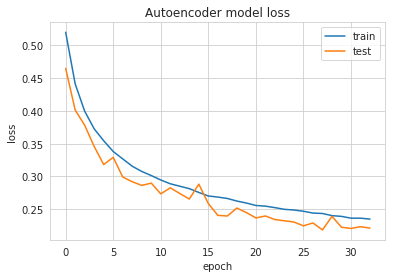

In [83]:
best_loss_value_ann_24n_unisoftsigbinlosadam = plot_hist_auto(hist_ann_24n_unisoftsigbinlosadam, './Figures/ann_24_unisoftsigbinlosadam.png')

In [84]:
pred_ann_24n_prob_unisoftsigbinlosadam, pred_ann_24n_01_unisoftsigbinlosadam = ann_predict(ann_24n_unisoftsigbinlosadam,test_x)

Overall accuracy of Neural Network model: 0.9010007579835441
              precision    recall  f1-score   support

           0       0.92      0.88      0.90     45805
           1       0.88      0.92      0.90     45226

   micro avg       0.90      0.90      0.90     91031
   macro avg       0.90      0.90      0.90     91031
weighted avg       0.90      0.90      0.90     91031



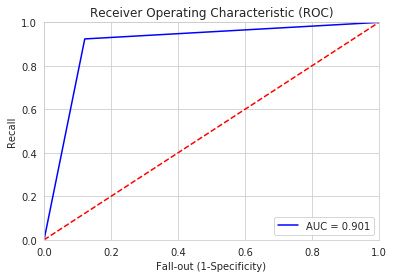

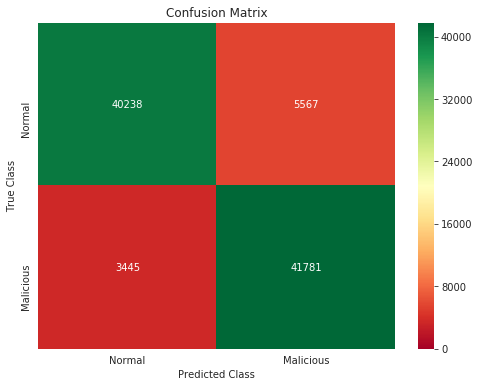

In [85]:
plot_roc_cm(pred_ann_24n_01_unisoftsigbinlosadam, pred_ann_24n_01_unisoftsigbinlosadam, './Figures/ROC_ann_24n_unisoftsigbinlosadam_redds10bal.png', './Figures/CM_ann_24n_unisoftsigbinlosadam_redds10bal.png')

In [86]:
from sklearn.ensemble import RandomForestClassifier

In [87]:
clf = RandomForestClassifier(n_estimators=300, 
                             criterion='gini', 
                             max_depth=16, 
#                              min_samples_split=2, 
                             #min_samples_leaf=1, 
                             max_features=0.3, 
                             #bootstrap=True,
                             oob_score=True,
                             random_state=23)  

In [88]:
start_time = time.time()
print(time.ctime(start_time))

clf.fit(enc_train_x_aslal, train_y)

pred_y_RF = cross_val_predict(estimator=clf,
                              X=np.array(enc_test_x_aslal),
                              y=test_y,
                              cv=KFold(n_splits=10, random_state=23),
                              n_jobs=2)

elapsed_time = (time.time() - start_time)
print("--- %s seconds ---" %elapsed_time)

print(sm.classification_report(test_y, pred_y_RF,digits=4))

Thu Jun  6 16:30:21 2019
--- 1587.528024673462 seconds ---
              precision    recall  f1-score   support

           0     0.9987    0.9819    0.9903     45805
           1     0.9820    0.9987    0.9903     45226

   micro avg     0.9903    0.9903    0.9903     91031
   macro avg     0.9904    0.9903    0.9903     91031
weighted avg     0.9904    0.9903    0.9903     91031



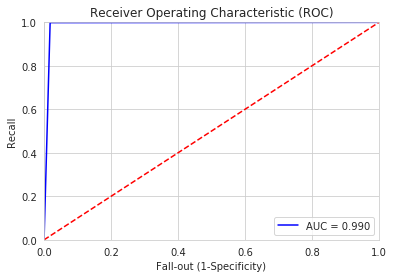

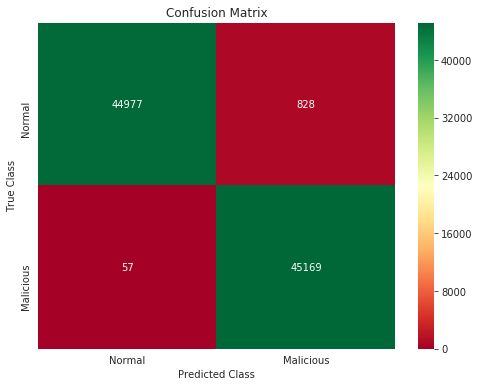

In [89]:
plot_roc_cm(pred_y_RF, pred_y_RF, './Figures/ROC_rf_E100MaxfautoMaxdnoneBootT_redds10bal.png', './Figures/CM_rf_E100MaxfautoMaxdnoneBootT_redds10bal.png')